In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
color = sns.color_palette()

%matplotlib inline

eng_stopwords = set(stopwords.words('english'))
pd.options.mode.chained_assignment = None

In [2]:
train_df = pd.read_csv('data/train/train.csv')
test_df = pd.read_csv('data/test/test.csv')
print('Number of rows in train dataset : ', train_df.shape[0])
print('Number of rows in test dataset : ', test_df.shape[0])

Number of rows in train dataset :  19579
Number of rows in test dataset :  8392


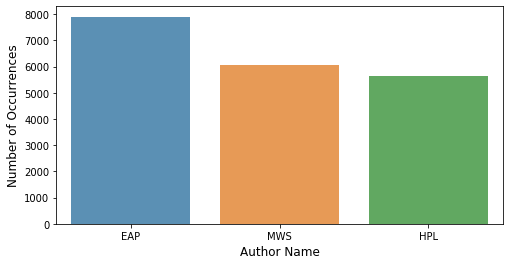

In [3]:
cnt_srs = train_df['author'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha = 0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Author Name', fontsize=12)
plt.show()

In [4]:
grouped_df = train_df.groupby('author')
for name, group in grouped_df:
    print('Author name : ', name)
    cnt = 0
    for ind, row in group.iterrows():
        print(row['text'])
        cnt+=1
        if cnt==5:
            break
    print('\n')

Author name :  EAP
This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.
The astronomer, perhaps, at this point, took refuge in the suggestion of non luminosity; and here analogy was suddenly let fall.
The surcingle hung in ribands from my body.
I knew that you could not say to yourself 'stereotomy' without being brought to think of atomies, and thus of the theories of Epicurus; and since, when we discussed this subject not very long ago, I mentioned to you how singularly, yet with how little notice, the vague guesses of that noble Greek had met with confirmation in the late nebular cosmogony, I felt that you coul

### feature engineering
- Meta features

In [5]:
train_df['num_words'] = train_df['text'].apply(lambda x : len(str(x).split()))
test_df['num_words'] = test_df['text'].apply(lambda x : len(str(x).split()))

train_df['num_unique_words'] = train_df['text'].apply(lambda x: len(set(str(x).split())))
test_df['num_unique_words'] = test_df['text'].apply(lambda x: len(set(str(x).split())))

train_df['num_chars'] = train_df['text'].apply(lambda x : len(str(x)))
test_df['num_chars'] = test_df['text'].apply(lambda x : len(str(x)))

train_df['num_stopwords'] = train_df['text'].apply(lambda x : len([w for w in str(x).lower().split() if w in eng_stopwords]))
test_df['num_stopwords'] = test_df['text'].apply(lambda x : len([w for w in str(x).lower().split() if w in eng_stopwords]))

train_df['num_punctuations'] = train_df['text'].apply(lambda x : len([c for c in str(x) if c in string.punctuation]))
test_df['num_punctuations'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

train_df['num_words_upper'] = train_df['text'].apply(lambda x : len([w for w in str(x).split() if w.isupper()]))
test_df['num_words_upper'] = test_df['text'].apply(lambda x : len([w for w in str(x).split() if w.isupper()]))

train_df['num_words_title'] = train_df['text'].apply(lambda x : len([w for w in str(x).split() if w.istitle()]))
test_df['num_words_title'] = test_df['text'].apply(lambda x : len([w for w in str(x).split() if w.istitle()]))

train_df['mean_word_len'] = train_df['text'].apply(lambda x : np.mean([len(w) for w in str(x).split()]))
test_df['mean_word_len'] = test_df['text'].apply(lambda x : np.mean([len(w) for w in str(x).split()]))

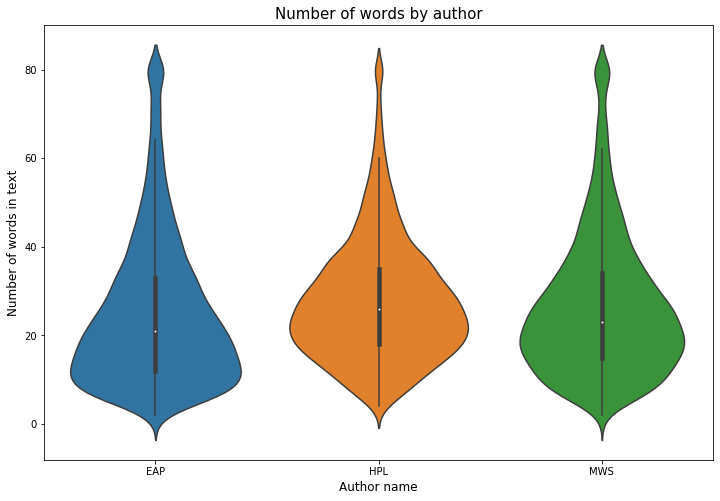

In [6]:
train_df['num_words'].loc[train_df['num_words'] > 80] = 80
plt.figure(figsize=(12,8))
sns.violinplot(x = 'author', y = 'num_words', data=train_df)
plt.xlabel('Author name' , fontsize=12)
plt.ylabel('Number of words in text', fontsize=12)
plt.title('Number of words by author', fontsize=15)
plt.show()

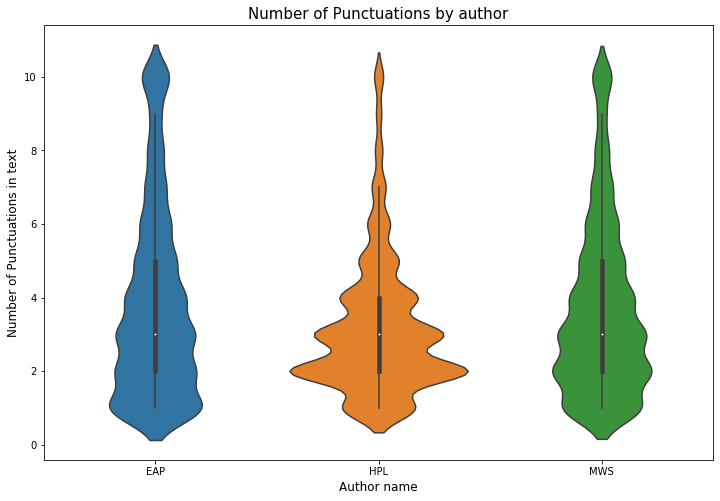

In [7]:
train_df['num_punctuations'].loc[train_df['num_punctuations'] > 10] = 10
plt.figure(figsize=(12,8))
sns.violinplot( x = 'author', y = 'num_punctuations', data = train_df)
plt.xlabel('Author name' , fontsize=12)
plt.ylabel('Number of Punctuations in text', fontsize=12)
plt.title('Number of Punctuations by author', fontsize=15)
plt.show()

In [8]:
#prepare the data for modeling
author_mapping_dict = {'EAP' : 0, 'HPL' : 1, 'MWS' : 2}
train_y = train_df['author'].map(author_mapping_dict)
train_id = train_df['id'].values
test_id = test_df['id'].values

train_df['num_words'] = train_df['text'].apply(lambda x : len(str(x).split()))
test_df['num_words'] = test_df['text'].apply(lambda x : len(str(x).split()))
train_df['mean_word_len'] = train_df['text'].apply(lambda x : np.mean([len(w) for w in str(x).split()]))
test_df['mean_word_len'] = test_df['text'].apply(lambda x : np.mean([len(w) for w in str(x).split()]))

cols_to_drop = ['id', 'text']
train_x = train_df.drop(cols_to_drop+['author'], axis = 1)
test_x = test_df.drop(cols_to_drop, axis =  1)

In [9]:
# Modelling XGB with only metadata

def runXGB(train_x, train_y, test_x, test_y=None, test_x2 = None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 3
    param['slient'] = 1
    param['num_class'] = 3
    param['eval_metric'] = 'mlogloss'
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 2000
    
    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_x, label = train_y)
    
    if test_y is not None:
        xgtest = xgb.DMatrix(test_x, label= test_y)
        watchlist = [(xgtrain, 'train'), (xgtest, 'test')]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds = 50, verbose_eval=50)
    
    else:
        xgtest = xgb.DMatrix(test_x)
        model = xgb.train(plst, xgtrain, num_rounds)
        
    pred_test_y = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    
    if test_x2 is not None:
        xgtest2 = xgb.DMatrix(test_x2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    
    return pred_test_y, pred_test_y2, model

In [10]:
kf = model_selection.KFold(n_splits = 5, shuffle = True, random_state = 2017)
cv_scores= []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_x):
    dev_x, val_x = train_x.loc[dev_index], train_x.loc[val_index]
    dev_y, val_y = train_y.loc[dev_index], train_y.loc[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_x, dev_y, val_x, val_y, test_x, seed_val=0)
    
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index , :] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    
print('cv scores  : ', cv_scores)

[0]	train-mlogloss:1.09384	test-mlogloss:1.09472
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[50]	train-mlogloss:1.01790	test-mlogloss:1.03469
[100]	train-mlogloss:0.98938	test-mlogloss:1.01345
[150]	train-mlogloss:0.97329	test-mlogloss:1.00366
[200]	train-mlogloss:0.96141	test-mlogloss:0.99788
[250]	train-mlogloss:0.95198	test-mlogloss:0.99457
[300]	train-mlogloss:0.94402	test-mlogloss:0.99235
[350]	train-mlogloss:0.93681	test-mlogloss:0.99061
[400]	train-mlogloss:0.93020	test-mlogloss:0.98917
[450]	train-mlogloss:0.92468	test-mlogloss:0.98877
Stopping. Best iteration:
[447]	train-mlogloss:0.92505	test-mlogloss:0.98876

[0]	train-mlogloss:1.09415	test-mlogloss:1.09400
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[50]	train-mlogloss:1.01987	test-mlogloss:1.02229
[100]	train-ml

> **Text Based Features**

In [11]:
# tf-idf 

tfidf_vec = TfidfVectorizer(stop_words = 'english', ngram_range=(1,3))
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())


In [12]:
# naive bayes model

def runMNB(train_x, train_y, test_x, test_y, test_x2):
    model = naive_bayes.MultinomialNB()
    model.fit(train_x, train_y)
    pred_test_y = model.predict_proba(test_x)
    pred_test_y2 = model.predict_proba(test_x2)
    return pred_test_y, pred_test_y2, model

In [13]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3 ])
kf = model_selection.KFold(n_splits= 5, shuffle = True, random_state = 2017)
for dev_index, val_index in kf.split(train_x):
    dev_x, val_x = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_x, dev_y, val_x, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index, : ] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print('Mean cv scores : ', np.mean(cv_scores))
pred_full_test = pred_full_test / 5.0

Mean cv scores :  0.8422161983612855


> **SVD on word TFIDF**

In [14]:
train_df

,id,text,author,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len
0,id26305,"This process, however, afforded me no means of...",EAP,41,35,231,19,7,2,3,4.658537
1,id17569,It never once occurred to me that the fumbling...,HPL,14,14,71,8,1,0,1,4.142857
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,36,32,200,16,5,0,1,4.583333
3,id27763,How lovely is spring As we looked from Windsor...,MWS,34,32,206,13,4,0,4,5.088235
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,27,25,174,11,4,0,2,5.481481
...,...,...,...,...,...,...,...,...,...,...,...
19574,id17718,"I could have fancied, while I looked at it, th...",EAP,20,19,108,11,3,2,2,4.450000
19575,id08973,The lids clenched themselves together as if in...,EAP,10,10,55,6,1,0,1,4.600000
19576,id05267,"Mais il faut agir that is to say, a Frenchman ...",EAP,13,13,68,4,2,0,2,4.307692
19577,id17513,"For an item of news like this, it strikes us i...",EAP,15,14,74,7,3,0,1,4.000000


In [15]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm = 'arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))

train_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)

# del full_tfidf, train_tf,idf, test_tfidf, train_svd, test_svd

> **Naive Bayes on Word Count Vectorizer**

In [16]:
wc_vec = CountVectorizer(stop_words='english', ngram_range=(1,3))
wc_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_wc_vec = wc_vec.transform(train_df['text'].values.tolist())
test_wc_vec = wc_vec.transform(test_df['text'].values.tolist())

In [17]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_x):
    dev_x, val_x = train_wc_vec[dev_index], train_wc_vec[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_x, dev_y, val_x, val_y, test_wc_vec)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index, : ] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print('Mean cv score : ', np.mean(cv_scores))
pred_full_test = pred_full_test / 5.0

#add the predictions as new features
train_df['nb_cvec_eap'] = pred_train[ : , 0]
train_df['nb_cvec_hpl'] = pred_train[ : , 1]
train_df['nb_cvec_mws'] = pred_train[ : , 2]

test_df['nb_cvec_eap'] = pred_full_test[ : , 0]
test_df['nb_cvec_hpl'] = pred_full_test[ : , 1]
test_df['nb_cvec_mws'] = pred_full_test[ : , 2]

Mean cv score :  0.45091841616567435


> **Naive Bayes on Character Count Vectorizer**

In [18]:
tfidf_vec = CountVectorizer(ngram_range = (1,7), analyzer='char')
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits = 5, shuffle =True, random_state=2017)
for dev_index, val_index in kf.split(train_x):
    dev_x, val_x = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_x, dev_y, val_x, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index, :] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print('Mean cv score : ', np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

train_df['nb_cvec_char_eap'] = pred_train[:,0]
train_df['nb_cvec_char_hpl'] = pred_train[:,1]
train_df['nb_cvec_char_mws'] = pred_train[:,2]

test_df['nb_cvec_char_eap'] = pred_full_test[:,0]
test_df['nb_cvec_char_hpl'] = pred_full_test[:,1]
test_df['nb_cvec_char_mws'] = pred_full_test[:,2]

Mean cv score :  3.7507639226818825


In [19]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,5), analyzer='char')
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0],3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_x):
    dev_x, val_x = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_x, dev_y, val_x, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index, : ] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print('mean cv score : ', np.mean(cv_scores))
pred_full_test = pred_full_test / 5.0

train_df['nb_tfidf_char_eap'] = pred_train[:,0]
train_df['nb_tfidf_char_hpl'] = pred_train[:,1]
train_df['nb_tfidf_char_mws'] = pred_train[:,2]

test_df["nb_tfidf_char_eap"] = pred_full_test[:,0]
test_df["nb_tfidf_char_hpl"] = pred_full_test[:,1]
test_df["nb_tfidf_char_mws"] = pred_full_test[:,2]

mean cv score :  0.790415258947421


> **SVD on Character TFIDF**

In [20]:
n_comp = 20
svd_obj = TruncatedSVD(n_components = n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))

train_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

> **XGBOOST**

In [21]:
cols_to_drop=['id', 'text']
train_x = train_df.drop(cols_to_drop + ['author'], axis=1)
test_x = test_df.drop(cols_to_drop, axis=1)

kf = model_selection.KFold(n_splits = 5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_x):
    dev_x, val_x = train_x.loc[dev_index], train_x.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_x, dev_y, val_x,val_y, test_x, seed_val = 0, colsample=0.7)
    pred_full_test += pred_test_y
    pred_train[val_index, : ] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print('cv scores : ', cv_scores)

out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)


[0]	train-mlogloss:1.00354	test-mlogloss:1.00354
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[50]	train-mlogloss:0.32453	test-mlogloss:0.34035
[100]	train-mlogloss:0.28281	test-mlogloss:0.31811
[150]	train-mlogloss:0.25774	test-mlogloss:0.31041
[200]	train-mlogloss:0.23812	test-mlogloss:0.30829
[250]	train-mlogloss:0.22205	test-mlogloss:0.30596
[300]	train-mlogloss:0.20734	test-mlogloss:0.30617
Stopping. Best iteration:
[251]	train-mlogloss:0.22165	test-mlogloss:0.30592

[0]	train-mlogloss:1.00352	test-mlogloss:1.00477
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[50]	train-mlogloss:0.32270	test-mlogloss:0.34499
[100]	train-mlogloss:0.27922	test-mlogloss:0.32354
[150]	train-mlogloss:0.25462	test-mlogloss:0.31807
[200]	train-mlogloss:0.23522	test-mlogloss:0.31463
[250]	train-ml

In [22]:
dev_x.columns

Index(['num_words', 'num_unique_words', 'num_chars', 'num_stopwords',
       'num_punctuations', 'num_words_upper', 'num_words_title',
       'mean_word_len', 'svd_word_0', 'svd_word_1', 'svd_word_2', 'svd_word_3',
       'svd_word_4', 'svd_word_5', 'svd_word_6', 'svd_word_7', 'svd_word_8',
       'svd_word_9', 'svd_word_10', 'svd_word_11', 'svd_word_12',
       'svd_word_13', 'svd_word_14', 'svd_word_15', 'svd_word_16',
       'svd_word_17', 'svd_word_18', 'svd_word_19', 'nb_cvec_eap',
       'nb_cvec_hpl', 'nb_cvec_mws', 'nb_cvec_char_eap', 'nb_cvec_char_hpl',
       'nb_cvec_char_mws', 'nb_tfidf_char_eap', 'nb_tfidf_char_hpl',
       'nb_tfidf_char_mws', 'svd_char_0', 'svd_char_1', 'svd_char_2',
       'svd_char_3', 'svd_char_4', 'svd_char_5', 'svd_char_6', 'svd_char_7',
       'svd_char_8', 'svd_char_9', 'svd_char_10', 'svd_char_11', 'svd_char_12',
       'svd_char_13', 'svd_char_14', 'svd_char_15', 'svd_char_16',
       'svd_char_17', 'svd_char_18', 'svd_char_19'],
      dtype='ob